<a href="https://colab.research.google.com/github/arguntolga/ts_jupyter/blob/main/abovebelowma9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Toplam Hisse:  102


[*********************100%%**********************]  102 of 102 completed


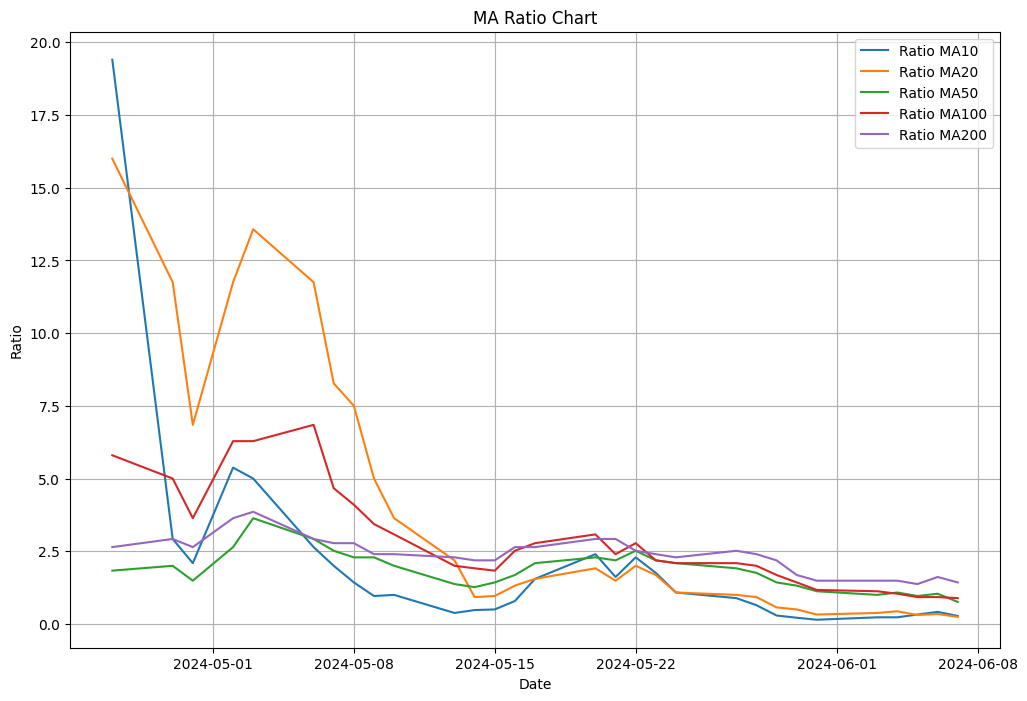

,Above MA10,Below MA10,Ratio MA10,Above MA20,Below MA20,Ratio MA20,Above MA50,Below MA50,Ratio MA50,Above MA100,Below MA100,Ratio MA100,Above MA200,Below MA200,Ratio MA200
2024-06-07,22,80,0.275000,20,82,0.243902,44,58,0.758621,48,54,0.888889,60,42,1.428571
2024-06-06,30,72,0.416667,26,76,0.342105,52,50,1.040000,49,53,0.924528,63,39,1.615385
2024-06-05,25,77,0.324675,24,78,0.307692,50,52,0.961538,49,53,0.924528,59,43,1.372093
2024-06-04,19,83,0.228916,31,71,0.436620,53,49,1.081633,52,50,1.040000,61,41,1.487805
2024-06-03,19,83,0.228916,28,74,0.378378,51,51,1.000000,54,48,1.125000,61,41,1.487805
2024-05-31,13,89,0.146067,25,77,0.324675,54,48,1.125000,55,47,1.170213,61,41,1.487805
2024-05-30,18,84,0.214286,34,68,0.500000,58,44,1.318182,60,42,1.428571,64,38,1.684211
2024-05-29,23,79,0.291139,37,65,0.569231,60,42,1.428571,64,38,1.684211,70,32,2.187500
2024-05-28,40,62,0.645161,49,53,0.924528,65,37,1.756757,68,34,2.000000,72,30,2.400000
2024-05-27,48,54,0.888889,51,51,1.000000,67,35,1.914286,69,33,2.090909,73,29,2.517241


In [5]:
import yfinance as yf
import pandas as pd
import pandas.api.types as pdtypes
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Define your two stock tickers
#stock_list = ["EREGL.IS", "FROTO.IS", "THYAO.IS", "TTRAK.IS", "MIATK.IS"]
stock_list = [
   "AGROT.IS","AKBNK.IS","AKSA.IS","AKSEN.IS","ALARK.IS","ALFAS.IS","ALGYO.IS",
   "ALKA.IS","ALKIM.IS","ANGEN.IS","ARCLK.IS","ARDYZ.IS","ASELS.IS","ASTOR.IS",
   "BIMAS.IS","BNTAS.IS","BOBET.IS","BRISA.IS","BRYAT.IS","CIMSA.IS","CLEBI.IS",
   "CVKMD.IS","CWENE.IS","DOAS.IS","DOHOL.IS","EGEEN.IS","EKGYO.IS","ELITE.IS",
   "ENJSA.IS","ENKAI.IS","ERBOS.IS","EREGL.IS","EUPWR.IS","FROTO.IS","GARAN.IS",
   "GESAN.IS","GUBRF.IS","GWIND.IS","HALKB.IS","HEKTS.IS","HKTM.IS","HUNER.IS",
   "IPEKE.IS","ISCTR.IS","ISGYO.IS","ISMEN.IS","ISYAT.IS","JANTS.IS","KAREL.IS",
   "KARSN.IS","KCHOL.IS","KLKIM.IS","KLSER.IS","KMPUR.IS","KONTR.IS","KONYA.IS",
   "KORDS.IS","KOZAA.IS","KOZAL.IS","KRDMD.IS","LOGO.IS","MAVI.IS","MGROS.IS",
   "MIATK.IS","ODAS.IS","ORGE.IS","OTKAR.IS","OYAKC.IS","PARSN.IS","PETKM.IS",
   "PGSUS.IS","PNLSN.IS","POLTK.IS","SAHOL.IS","SASA.IS","SAYAS.IS","SISE.IS",
   "SMRTG.IS","SOKM.IS","SUWEN.IS","TABGD.IS","TAVHL.IS","TCELL.IS","TEZOL.IS",
   "THYAO.IS","TKFEN.IS","TKNSA.IS","TOASO.IS","TTKOM.IS","TTRAK.IS","TUKAS.IS",
   "TUPRS.IS","ULKER.IS","ULUUN.IS","VESBE.IS","VESTL.IS","YAPRK.IS","YATAS.IS",
   "YEOTK.IS","YKBNK.IS","YUNSA.IS","YYLGD.IS"
]

print("Toplam Hisse: ", len(stock_list))

# Set start and end dates
start_date = "2023-05-04"
end_date = "2024-08-03"

# Download data using yfinance
data = yf.download(stock_list, start=start_date, end=end_date)["Adj Close"]
data = data.fillna(0)
data.index = data.index.date
#display(data)

def calculate_moving_averages(stock_list, data, window_sizes):
  for stock in stock_list:
    for window in window_sizes:
      data[stock + '_MA_' + str(window)] = data[stock].rolling(window=window).mean()
  return data

def calculate_above_below_ma(stock_list, data, window_sizes):
  above_below_counts = {}
  for date in data.index:
    daily_counts = {}
    for window in window_sizes:
      above_count = 0
      for stock in stock_list:
        ma_col = f"{stock}_MA_{window}"
        above_count += (data.loc[date, stock] > data.loc[date, ma_col])
      below_count = len(stock_list) - above_count
      daily_counts["Above MA" + str(window)] = above_count
      daily_counts["Below MA" + str(window)] = below_count
      daily_counts["Ratio MA" + str(window)] = above_count / max(1,below_count)
    above_below_counts[date] = daily_counts
  return pd.DataFrame(above_below_counts).transpose()


def calculate_super_stock(stock_list, data, window_sizes):
  super_stock = 0
  super_stock_df = pd.DataFrame(index=data.index, columns=stock_list)
  for date in data.index:
    for stock in stock_list:
      super_stock_level = 0
      if data.loc[date, stock] > data.loc[date, f"{stock}_MA_{window_sizes[0]}"]:
          super_stock_level += 1
      for window_idx in range(len(window_sizes) - 1):
        current_ma_col = f"{stock}_MA_{window_sizes[window_idx]}"
        next_ma_col = f"{stock}_MA_{window_sizes[window_idx + 1]}"
        if data.loc[date, current_ma_col] > data.loc[date, next_ma_col]:
          super_stock_level += 1
      super_stock_df.loc[date, stock] = int(super_stock_level)
  return super_stock_df


# Define window sizes for moving averages
window_sizes = [10, 20, 50, 100, 200]

# Apply the moving average calculation
data_with_ma = calculate_moving_averages(stock_list, data.copy(), window_sizes)
data_with_ma = data_with_ma.fillna(0)
#display(data_with_ma)

def drop_oldest_rows(data, n_rows_to_drop):
  # Sort by index (assuming it's a date index)
  data_sorted = data.sort_index()
  # Select and drop the oldest N rows using iloc (integer location based indexing)
  data_dropped = data_sorted.iloc[n_rows_to_drop:]
  return data_dropped

data_dropped_ma = drop_oldest_rows(data_with_ma.copy(), 200)

# Calculate above/below MA counts
above_below_data = calculate_above_below_ma(stock_list, data_dropped_ma.copy(), window_sizes)
#print(above_below_data)

def green_red(value):
    if value < 1:
        return 'color: red; font-weight: bold'
    elif value > 2:
        return 'color: green; font-weight: bold'
    else:
        return None

above_below_reversed = above_below_data.iloc[::-1]
#above_below_reversed.style.applymap(green_red)

def convert_to_int_if_zero_fraction(df):
  # Select numeric columns only (avoid errors with non-numeric data)
  numeric_cols = df.select_dtypes(include=[np.number])
  for col in numeric_cols:
    # Apply conversion function to the selected numeric column
    df[col] = df[col].apply(lambda x: int(x) if isinstance(x, (int, float)) and x % 1 == 0 else x)
  return df

# Apply conversion to all numeric columns
above_below_reversed = convert_to_int_if_zero_fraction(above_below_reversed.copy())  # Operate on a copy to avoid modifying original data

# Assuming 'Date' is the index (set as index if needed: df.set_index('Date'))
last_n_data = above_below_reversed.iloc[:30]
last_n_data.plot.line(y=['Ratio MA10', 'Ratio MA20', 'Ratio MA50', 'Ratio MA100', 'Ratio MA200'], figsize=(12, 8))  # Adjust figsize for customization
plt.title("MA Ratio Chart")
plt.xlabel("Date")
plt.ylabel("Ratio")
plt.grid(True)
plt.show()

def ratio_subset(window_sizes):
   ratio_column_array = []
   for window in window_sizes:
     ratio_column_array.append("Ratio MA" + str(window))
   return ratio_column_array

above_below_reversed.style.applymap(green_red, subset = ratio_subset(window_sizes))



#display(above_below_data.iloc[::-1])

#super_stock_data = calculate_super_stock(stock_list, data_dropped_ma, window_sizes)
#cm = sns.light_palette("green", as_cmap=True)
#super_stock_data.iloc[::-1].apply(pd.to_numeric).style.set_sticky(axis=1).background_gradient(cmap=cm)